Tools

In [41]:
import sys  
sys.path.append('/home/josorior/kinetick/source')

In [58]:
# Standard tool packages
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, jacfwd, hessian
from jax import vmap
import jax.numpy as jnp
from jax.numpy import logical_and
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
# My tools
from models import *
from mykernels import get_gaussianRBF
# Settings
#plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 5)

## PDE

Let $M(x) = \exp\left(-0.5(x_1^2 + x_2^2)\right)$. The Fokker-Planck equation in 2d is given by
$$
\begin{align*}

\partial_t \rho (t,x) &= \text{div}\left(M(x)\nabla\left(\frac{\rho(t,x)}{M(x)}\right)\right) & \text{for } t >0, x \in \Omega = (-3,3)^2 \\
\rho(0,x) &= \rho^0(x), &\text{for } x \in \Omega \\
\nabla\left(\frac{\rho(t,x)}{M(x)} \cdot \mathbf{n}\right) &= 0, & \text{for } t >0, x \in \partial\Omega = (-3,3)^2
\end{align*}
$$
whose analytical solution is known to be
$$
\rho(t, x)=\frac{1}{2 \pi\left(1-e^{-2 t}\right)} e^{-\frac{x_1^2+x_2^2}{2\left(1-e^{-2 t}\right)}}.
$$

We will use the kernel method in closed form since the PDE operator is linear.


## Kernel solution

Choose a kernel

In [43]:
k = get_gaussianRBF(0.2)

Note: This is 2d time dependent problem meaning that the kernel actually is of the form
$$
K(s,w)
$$
where $s = (t,x_1,x_2)$ and $w = (\tau,y_1,y_2)$

First we choose collocation pointsets $\Omega^*\subset\Omega$ and $\Omega^*\subset\partial\Omega$

In [44]:
# \Omega
M_int = int(jnp.sqrt(500))
x_1 = jnp.linspace(-3,3,M_int)[1:]
x_2 = x_1
X_1, X_2 = jnp.meshgrid(x_1, x_2)
pairs_int = jnp.vstack([X_1.ravel(),X_2.ravel()]).T
M_int = pairs_int.shape[0]
# \partial\Omega
M_bdry = int(25*4)
bottom = jnp.vstack((jnp.linspace(-3,3,M_bdry//4), jnp.tile(-3,M_bdry//4))).T
top = jnp.vstack((jnp.linspace(-3,3,M_bdry//4), jnp.tile(3,M_bdry//4))).T
left = jnp.vstack((jnp.tile(-3,M_bdry//4),jnp.linspace(-3,3,M_bdry//4))).T[1:-1]
right = jnp.vstack((jnp.tile(3,M_bdry//4),jnp.linspace(-3,3,M_bdry//4))).T[1:-1]
pairs_bdry = jnp.vstack((left,bottom,right,top))
M_bdry = pairs_bdry.shape[0]

Build the kernel matrix $K(\phi,\phi)$ where $\phi = [\phi_\Omega, \phi_{\partial\Omega}]$ and
$$
\phi_\Omega \left(\square\right) = \delta_{x}\left(\square\right) - h\left(\delta_{x} \circ \text{div}\left(M(x)\nabla\left(\frac{\square}{M(x)}\right)\right)\right) \qquad \text{for } x\in \Omega
$$
$$
\phi_{\partial\Omega} \left(\square\right) = \delta_{x} \circ \nabla\left(\frac{\square}{M(x)}\right) \cdot \mathbf{n} = \qquad \text{for } x\in \partial \Omega
$$
Thus, the matrix has the form
$$
K(\phi,\phi) = 
\begin{pmatrix}
\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) \\
\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) \\
\end{pmatrix}
$$
where for instance the block $\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right)$ is evaluated as:

1. Apply $\phi_{\partial\Omega}$ to the function $K(x,y)$ as a function of $x$ only. 

2. Apply $\phi_\Omega$ to $\phi_{\partial\Omega}\left(K(x,y)\right)$ as a function of $y$ only.

Let's compute the blocks.

$$\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right)$$

In [45]:
def get_M(index):
    @jit
    def M(x,y):
        first = jnp.exp(-(jnp.sum(x**2))/ 2.)
        secnd = jnp.exp(-(jnp.sum(y**2))/ 2.) 
        return jnp.where(index == 0, first, secnd)
    return M
  
def n_aux(z):
    c_right = z[0] == 3.
    c_top = z[1] == 3.
    c_left = z[0] == -3.
    conds = [c_right,c_top,c_left]
    outs = [jnp.array([1.,0.]),jnp.array([0.,1.]),jnp.array([-1.,0.])]
    d = jnp.array([0.,-1.])
    return jnp.select(conds, outs, default = d)
    
def get_n(index):
    @jit
    def n(x,y):
        first = n_aux(x)
        secnd = n_aux(y)
        return jnp.where(index == 0, first, secnd)
    return n

def fp_2d_sol(t,x):
    K = 2*(1-jnp.exp(-2*t))
    return 1/(K*jnp.pi)*jnp.exp(-(jnp.sum(x**2))/K)

fp_2d_sol = vmap(fp_2d_sol,in_axes=(None,0))

In [46]:
def vectorize_kfunc(k):
    return vmap(vmap(k, in_axes=(None,0)), in_axes=(0,None))

def op_k_apply(k,L_op,R_op):
    return R_op(L_op(k,0),1)

def make_block(k,L_op,R_op):
    return vectorize_kfunc(op_k_apply(k,L_op,R_op))

In [47]:
def get_div(f,g):
    def f_op_g(x,y):
        return f(x,y) / g(x,y)
    return f_op_g

def get_mult(f,g):
    def f_op_g(x,y):
        return f(x,y) * g(x,y)
    return f_op_g

def get_sum(f,g):
    def f_op_g(x,y):
        return f(x,y) + g(x,y)
    return f_op_g

def get_subs(f,g):
    def f_op_g(x,y):
        return f(x,y) - g(x,y)
    return f_op_g

def get_const(h):
    def constant(*args):
        return h
    return constant

def get_dot(f,g):
    def dot_f(x,y):
        return jnp.dot(f(x,y),g(x,y))
    return dot_f

In [48]:
def eval_k(k,index):
    return k

def get_grad(k,index):
    return grad(k,index)

def divergence_k(k,index):
    def divk(*args):
        return jnp.trace(jacfwd(k,index)(*args))
    return divk


h = 0.1
def phi_omega(k,index):
    return get_subs(eval_k(k,index),
                   get_mult(get_const(h),
                            divergence_k(get_mult(get_M(index),get_grad(get_div(k,get_M(index)),index)),index)))
def phi_pomega(k,index):
    return get_dot(get_n(index),get_grad(get_div(k,get_M(index)),index))


## One step forward

Build $K(\phi,\phi)$

In [49]:
b11 = make_block(k,phi_omega,phi_omega)(pairs_int,pairs_int)
b21 = make_block(k,phi_omega,phi_pomega)(pairs_bdry,pairs_int)
b12 = b21.T
b22 = make_block(k,phi_pomega,phi_pomega)(pairs_bdry,pairs_bdry)

k_pp = jnp.block([[b11,b12],
                [b21,b22]])
k_pp = k_pp + 1e-8*jnp.diag(jnp.diag(k_pp))

Build $\beta = K(\phi,\phi)z$

In [50]:
# beta
z_star = jnp.concatenate([fp_2d_sol(0.1,pairs_int),jnp.zeros(pairs_bdry.shape[0])])

beta = jnp.linalg.solve(k_pp,z_star)

Build $\hat \rho(x) = K(x,\phi)^\top\beta$

In [51]:
@jit
def rho_star(x):
    b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pairs_int)
    b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pairs_bdry)
    return jnp.block([[b1,b2]]) @ beta

Compute $\hat \rho (X)$ and $\rho (X)$

In [52]:
pred = rho_star(pairs_int)
true = fp_2d_sol(0.1+h,pairs_int)

NMSE: 0.12


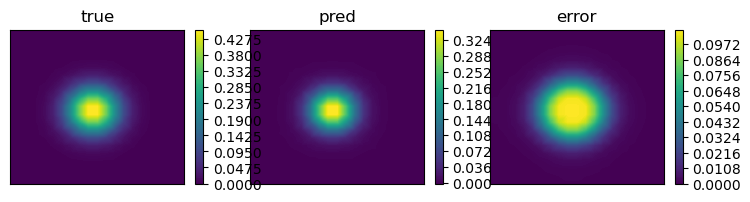

In [59]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# True
axs0 = axs[0].tricontourf(*pairs_int.T,true,200)
axs[0].title.set_text('true')
plt.colorbar(axs0, ax = axs[0])
# Pred
axs1 = axs[1].tricontourf(*pairs_int.T,pred,200)
axs[1].title.set_text('pred')
plt.colorbar(axs1, ax = axs[1])
# Error
axs2 = axs[2].tricontourf(*pairs_int.T,jnp.abs(pred-true),200)
axs[2].title.set_text('error')
plt.colorbar(axs2, ax = axs[2])
# Plot settings
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
nmse = mean_squared_error(pred,true)/mean_squared_error(0*pred,true)
print("NMSE:", round(nmse,2))
plt.show()

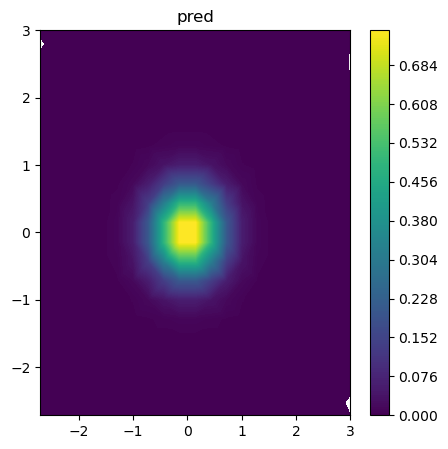

In [13]:
plt.tricontourf(*pairs_int.T,pred,200)
plt.title('pred')
plt.colorbar()
plt.show()

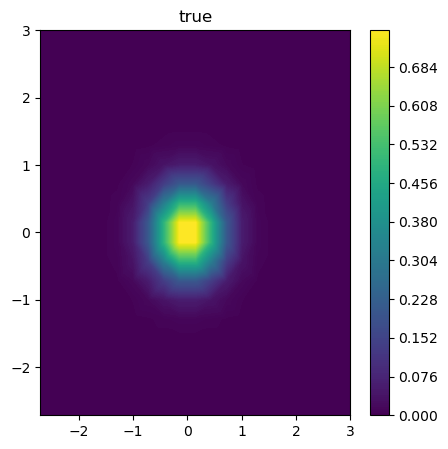

In [14]:
plt.tricontourf(*pairs_int.T,true,200)
plt.title('true')
plt.colorbar()
plt.show()

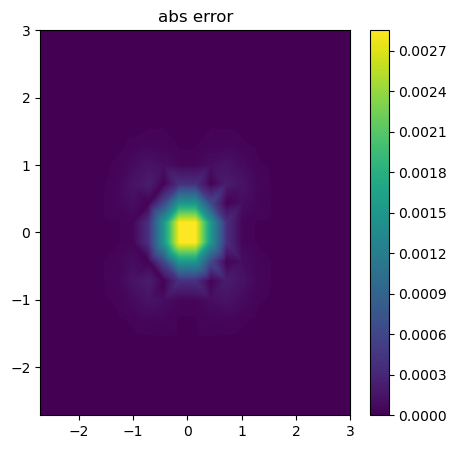

In [15]:
plt.tricontourf(*pairs_int.T,np.abs(pred-true),200)
plt.title('abs error')
plt.colorbar()
plt.show()

## Multiple steps

In [47]:
previous = fp_2d_sol(0.1,pairs_int)
steps = 1
print('final time:', 0.1 + steps*h)
for _ in range(steps):
    z_star = jnp.concatenate([previous,jnp.zeros(pairs_bdry.shape[0])])
    beta = jnp.linalg.solve(k_pp,z_star)
    b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(pairs_int,pairs_int)
    b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(pairs_int,pairs_bdry)
    pred = jnp.block([[b1,b2]]) @ beta
    #update
    previous = pred.copy()

final time: 0.15000000000000002


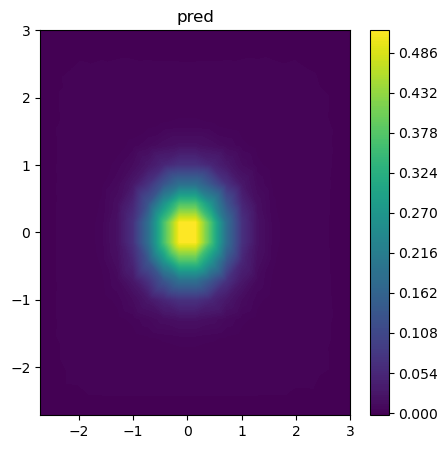

In [48]:
plt.tricontourf(*pairs_int.T,previous,200)
plt.title('pred')
plt.colorbar()
plt.show()

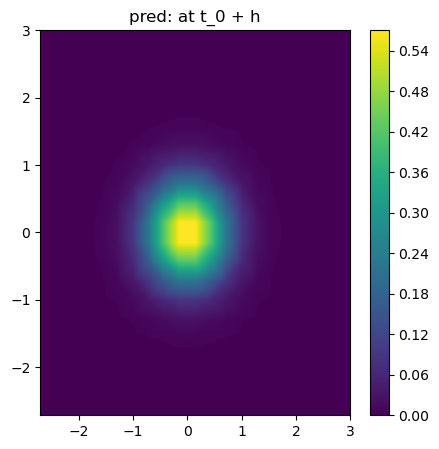

In [49]:
plt.tricontourf(*pairs_int.T,fp_2d_sol(0.1+steps*h,pairs_int),200)
plt.title('pred: at t_0 + h')
plt.colorbar()
plt.show()

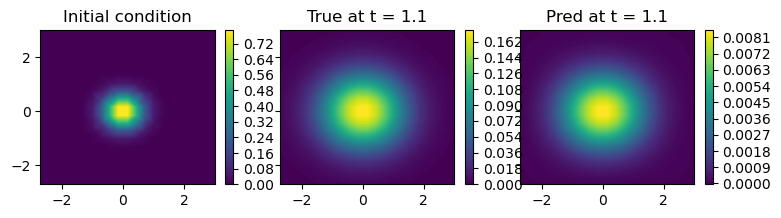

In [38]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# fig.suptitle('t=0.1 | true at t= {} | pred at t={}'.format(final_t,final_t))
# Initial condition
axs0 = axs[0].tricontourf(*pairs_int.T,fp_2d_sol(0.1,pairs_int),200)
axs[0].title.set_text('Initial condition')
plt.colorbar(axs0, ax = axs[0])
# True next
axs1 = axs[1].tricontourf(*pairs_int.T,fp_2d_sol(0.1 + steps*h,pairs_int),200)
axs[1].title.set_text('True at t = {}'.format(0.1 + steps*h))
plt.colorbar(axs1, ax = axs[1])
# Predicted next
axs2 = axs[2].tricontourf(*pairs_int.T,previous,200)
axs[2].title.set_text('Pred at t = {}'.format(0.1 + steps*h))
plt.colorbar(axs2, ax = axs[2])
# Plot settings
# for i in range(3):
#     axs[i].set_yticklabels([])
#     axs[i].set_xticklabels([])
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
#nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.show()